In [1]:
import numpy as np
from scipy import optimize
from numba import vectorize, float32, float64
import torch
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['science','notebook'])

from pydftlj.dft3d import dft3d
from pydftlj.eos import LJEOS 

from pymatgen.core import Structure
from pymatgen.analysis import structure_matcher

# Author: Elvis do A. Soares
# Github: @elvissoares
# Date: 2023-05-29

In [2]:
kB = 1.380649e-23 # J/K
Rconst = 0.082057366080960 # Gas constant
NA = 6.022e23 # Avogadro number

## Solid CIF file Information

In [3]:
structure_name = 'MOF-5'
structure = Structure.from_file('structures/'+structure_name+'.cif')
Ncell = 3
structure.make_supercell(Ncell)
print('formula:  ', structure.formula)
print('num_sites:', structure.num_sites)

formula:   Zn864 H2592 C5184 O2808
num_sites: 11448


In [4]:
coordinates = structure.cart_coords.T
L = np.array([l/Ncell for l in structure.lattice.lengths])
print('Cell dimensions: ', L)
Vcell = L[0]*L[1]*L[2]
print('Cell volume: ', Vcell)

Cell dimensions:  [25.86584 25.86584 25.86584]
Cell volume:  17305.325019903627


# Force Field for solid-fluid interaction

In [5]:
forcefield_name = 'DREIDING'
forcefield = pd.read_csv('parameters/'+forcefield_name+'-forcefield.dat',delim_whitespace=True)
forcefield

,atom,sigma/AA,epsilon/kB,mass/u
0,H,2.84642,7.64893,1.00784
1,C,3.47299,47.85620,12.01070
2,N,3.26256,38.94920,14.00670
3,O,3.03315,48.15810,15.99900
4,Cu,3.11369,2.51610,63.54600
5,Zn,4.04468,27.67710,65.38000


# Fluid Information

In [6]:
# PCSAFT: Gross, J., & Sadowski, G. (2001). Industrial & Engineering Chemistry Research, 40(4), 1244–1260.
# TraPPE: M.G. Martin, and J.I. Siepmann, J. Phys. Chem. B 102, 2569-2577 (1998).
# SoftSAFT: Blas, F. J., & Vega, L. F. (1998). Industrial and Engineering Chemistry Research, 5885(1996), 660–674.
fluid_molecule = 'CH4'
epsilon = {'TraPPE': 148.0, 'PCSAFT': 150.03, 'SoftSAFT': 147.302}
sigma = {'TraPPE': 3.73, 'PCSAFT': 3.704, 'SoftSAFT': 3.722}

fluid_forcefield = 'TraPPE'
epsilonff = epsilon[fluid_forcefield] # kelvin
sigmaff = sigma[fluid_forcefield] # angstrom
mff = 16.043

In [7]:
#Helium parameters for pycnometer
epsilonHe = 10.22 # kelvin
sigmaHe = 2.58  # angstrom

# Create the DFT object

In [38]:
Ngrid = 64
DFT = dft3d(gridsize=np.array([Ngrid,Ngrid,Ngrid]),ljmethod='MMFA',padding=False)
DFT.Set_Geometry(L)

In [39]:
DFT.GetSystemInformation()

============== The DFT 3D for LJ fluids ==============
Methods:
HS method =  WBI
LJ method =  MMFA
The grid is [64 64 64]
--- Geometry properties ---
Lx = 25.865840000000002  A
Ly = 25.865840000000002  A
Lz = 25.865840000000002  A
delta =  [0.40415375 0.40415375 0.40415375]  A
Vol = 17305.325019903627  A³


In [40]:
DFT.Set_FluidProperties(sigma=sigmaff,epsilon=epsilonff)

In [41]:
DFT.GetFluidInformation()

--- Fluid properties ---
epsilon/kB = 148.0  K
sigma = 3.73  A


## Generating the External Potential

In [42]:
@vectorize
def ljpotential(r,eps,sigma):
    return 4*eps*((sigma/r)**(12)-(sigma/r)**(6))

In [43]:
%%time

mss = 0.0

Vext = np.zeros((Ngrid,Ngrid,Ngrid))
Vext_helium = np.zeros((Ngrid,Ngrid,Ngrid))

# Lorentz-Berthelot combination rule
for i, site in enumerate(structure):
    sigmasf = float(0.5*(sigmaff+forcefield["sigma/AA"][forcefield["atom"]==site.species_string]))
    epsilonsf = float(np.sqrt(epsilonff*forcefield["epsilon/kB"][forcefield["atom"]==site.species_string]))
    mss += float(forcefield["mass/u"][forcefield["atom"]==site.species_string])

    R = np.sqrt((DFT.X-structure.cart_coords[i,0]+0.5*Ncell*L[0])**2 + (DFT.Y-structure.cart_coords[i,1]+0.5*Ncell*L[1])**2 + (DFT.Z-structure.cart_coords[i,2]+0.5*Ncell*L[2])**2)
    Vext[:] += ljpotential(R,epsilonsf,sigmasf)

    sigmasHe = float(0.5*(sigmaHe+forcefield["sigma/AA"][forcefield["atom"]==site.species_string]))
    epsilonsHe = float(np.sqrt(epsilonHe*forcefield["epsilon/kB"][forcefield["atom"]==site.species_string]))

    Vext_helium[:] += ljpotential(R,epsilonsHe,sigmasHe)

mss = mss/(Ncell**3)

del R

DFT.Set_External_Potential(Vext)

CPU times: user 3min 22s, sys: 88.6 ms, total: 3min 22s
Wall time: 3min 22s


In [44]:
print('Unit cell mass: ', mss, ' u')

Unit cell mass:  6158.863040000394  u


In [45]:
rhocr = 1e27*mss/(Vcell*NA) #kg/m3 crystal MOF-5 density

In [46]:
print('Crystal Density: ',rhocr,' kg/m3')

Crystal Density:  590.9898672924245  kg/m3


## Defining the Temperature

In [47]:
kT = 300.0 # kelvin 
DFT.Set_Temperature(kT)

In [48]:
DFT.GetFluidTemperatureInformation()

Temperature = 300.0  K
Baker-Henderson diameter = 3.567  A


In [49]:
Vpore_calc = np.exp(-Vext_helium/298.15).sum()*DFT.dV
Vpore_fluid = np.exp(-DFT.beta*Vext).sum()*DFT.dV

print(f'Calculated pore volume for He atom is {Vpore_calc} A³')
print(f'Calculated pore volume for the fluid is {Vpore_fluid} A³')

Calculated pore volume for He atom is 13963.269349016711 A³
Calculated pore volume for the fluid is 118375.94537599378 A³


In [50]:
helium_fraction = Vpore_calc/Vcell

print(f'Calculated He void fraction is {helium_fraction:1.3f}')

Calculated He void fraction is 0.807


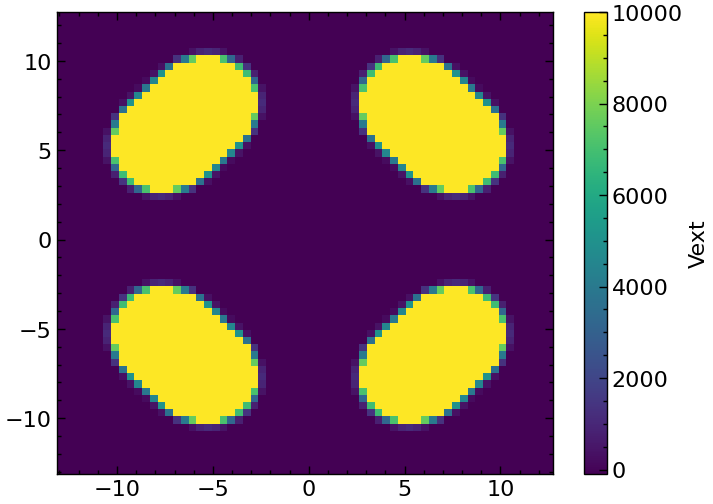

In [51]:
plt.figure(figsize=(8,6))
c=plt.pcolormesh(DFT.X[:,:,Ngrid//2],DFT.Y[:,:,Ngrid//2],DFT.Vext[:,:,Ngrid//2].cpu(), cmap='viridis',vmin=-1e2,vmax=1e4)
plt.colorbar(label='Vext')
plt.show()

In [52]:
ljeos= LJEOS(sigma=sigmaff,epsilon=epsilonff,model='MBWR')

In [53]:
def rhofromBARpressure(pbar):
    def func(x,p):
        return ljeos.p(x,kT)-p,ljeos.dpdrho(x,kT), ljeos.d2pdrho2(x,kT)
    if np.isscalar(pbar):
        sol = optimize.root_scalar(func, x0=1e-2, fprime=True,fprime2=True,args=(1e-30*pbar/(1e-5*kB)), method='halley')
        rho = sol.root
    else:
        rho = np.empty_like(pbar)
        sol = optimize.root_scalar(func, x0=1e-2, fprime=True,fprime2=True,args=(1e-30*pbar[0]/(1e-5*kB)), method='halley')
        rho[0] = sol.root
        for i in range(1,pbar.size):
            sol = optimize.root_scalar(func, x0=rho[i-1], fprime=True,fprime2=True,args=(1e-30*pbar[i]/(1e-5*kB)), method='halley')
            rho[i] = sol.root
    return rho

In [54]:
pbararray = np.hstack((np.arange(0.05,2.0,0.05),np.arange(2.,101,1.0),np.arange(110,510,10.0))) # bulk pressure (in bar)

In [55]:
rhobarray = rhofromBARpressure(pbararray)

Text(0, 0.5, '$\\rho_b$ (molecules/$\\AA^{3}$)')

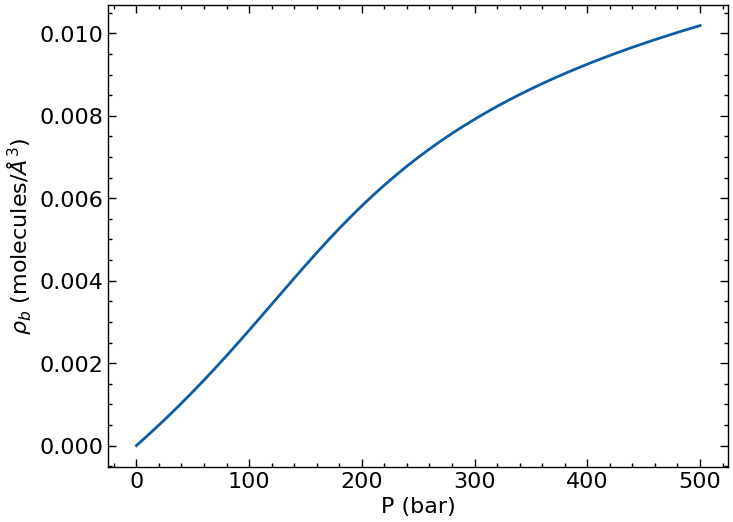

In [56]:
plt.plot(pbararray,rhobarray)
plt.xlabel(r'P (bar)')
plt.ylabel(r'$\rho_b$ (molecules/$\AA^{3}$)')

In [57]:
%%time

Nexcarray = np.zeros_like(rhobarray) # Excess adsorbed quantity

DFT.Set_BulkDensity(rhobarray[0])
DFT.Set_InitialCondition()

print('P (bar)\t rhob (AA^-3)\t Nabs(molecules/u.c.)')

for i in range(rhobarray.size):
    rhob = rhobarray[i]

    DFT.Set_BulkDensity(rhob)

    DFT.Calculate_Equilibrium(alpha0=0.1,dt=0.1,method='fire',logoutput=False)

    Nexcarray[i] = DFT.Nabs - DFT.rhob*Vpore_calc
    print(pbararray[i].round(2),rhob,Nexcarray[i].round(3))

P (bar)	 rhob (AA^-3)	 Nabs(molecules/u.c.)


/home/elvis/Google Drive/Projetos em Andamento/2-DFT in Amorphous Carbon/codes/PyDFTlj/pydftlj/dft3d.py:275: RuntimeWarning: invalid value encountered in dphi3dnfuncWBI
  self.dphi3dn3 = torch.tensor(dphi3dnfuncWBI(self.n3.numpy()),dtype=torch.float32)


0.05 1.2072577617596054e-06 0.122
0.1 2.414707548641259e-06 0.248
0.15 3.622349371072641e-06 0.375
0.2 4.830183239486024e-06 0.501
0.25 6.0382091643182445e-06 0.627
0.3 7.246427156010674e-06 0.753
0.35 8.454837225009188e-06 0.879
0.4 9.663439381764134e-06 1.006
0.45 1.0872233636730307e-05 1.132
0.5 1.2081220000366911e-05 1.258
0.55 1.3290398483137537e-05 1.384
0.6 1.4499769095510124e-05 1.51
0.65 1.570933184795694e-05 1.636
0.7 1.6919086750954526e-05 1.763
0.75 1.8129033814983706e-05 1.889
0.8 1.933917305052952e-05 2.015
0.85 2.054950446808122e-05 2.141
0.9 2.1760028078132198e-05 2.267
0.95 2.297074389118e-05 2.394
1.0 2.4181651917726278e-05 2.52
1.05 2.5392752168276746e-05 2.646
1.1 2.6604044653341173e-05 2.772
1.15 2.7815529383433327e-05 2.898
1.2 2.9027206369070943e-05 3.025
1.25 3.0239075620775717e-05 3.151
1.3 3.1451137149073254e-05 3.277
1.35 3.266339096449305e-05 3.403
1.4 3.387583707756842e-05 3.529
1.45 3.508847549883652e-05 3.656
1.5 3.630130623883828e-05 3.782
1.55 3.7514329

In [58]:
# helium_void_fraction = Vpore/Vcell
helium_void_fraction = 0.852

Vpore = helium_void_fraction*Vcell

In [59]:
Mexcarray = Nexcarray*mff

In [60]:
df = pd.DataFrame()
df['Pressure (bar)'] = pbararray
df['Excess adsorption (molecules/uc)'] = Nexcarray
df['Excess adsorption (molecules/nm^3)'] = Nexcarray/(Vcell*1e-3)
df['Excess adsorption (mg/g)'] = 1e3*Mexcarray/mss
df['Excess adsorption (%w.t.)'] = 100*Mexcarray/(mss+Mexcarray)
df['Excess adsorption (mol/kg)'] = 1e3*Nexcarray/mss
df['Excess adsorption (cm^3 STP/cm^3)'] = 1e30*(kB*273.15/1e5)*Nexcarray/Vcell

In [61]:
df.head()

,Pressure (bar),Excess adsorption (molecules/uc),Excess adsorption (molecules/nm^3),Excess adsorption (mg/g),Excess adsorption (%w.t.),Excess adsorption (mol/kg),Excess adsorption (cm^3 STP/cm^3)
0,0.05,0.121837,0.007040,0.317370,0.031727,0.019782,0.265513
1,0.10,0.248216,0.014343,0.646570,0.064615,0.040302,0.540922
2,0.15,0.374749,0.021655,0.976171,0.097522,0.060847,0.816668
3,0.20,0.501005,0.028951,1.305049,0.130335,0.081347,1.091808
4,0.25,0.627182,0.036242,1.633725,0.163106,0.101834,1.366780


In [62]:
# df.to_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-'+fluid_forcefield+'-'+forcefield_name+'-T='+str(kT)+'K-N='+str(Ngrid)+'-ljmethod='+str(DFT.ljmethod)+'.dat', index=False,sep='\t')

# Plotting the results

In [63]:
exp_data = pd.read_excel('data/experimental/H2andCH4-MOFandZIF-isotherm-Zhou2007.xls',sheet_name='CH4-MOF5')
exp_data2 = pd.read_excel('data/experimental/CH4-MOF-isotherm-Duren2004.xls',sheet_name='IRMOF-1')

In [64]:
def rhofromBARpressure300K(pbar):
    def func(x,p):
        return ljeos.p(x,298)-p,ljeos.dpdrho(x,298), ljeos.d2pdrho2(x,298)
    rho = np.empty_like(pbar)
    sol = optimize.root_scalar(func, x0=1e-2, fprime=True,fprime2=True,args=(1e-30*pbar[0]/(1e-5*kB)), method='halley')
    rho[0] = sol.root
    for i in range(1,pbar.size):
        sol = optimize.root_scalar(func, x0=rho[i-1], fprime=True,fprime2=True,args=(1e-30*pbar[i]/(1e-5*kB)), method='halley')
        rho[i] = sol.root
    return rho

In [65]:

exp_data3 = pd.read_excel('data/experimental/CH4-MOF-isotherm-Pillai2015.xls',sheet_name='IRMOF-1')
exp_data4 = pd.read_excel('data/experimental/CH4-MOF-isotherm-Fu2015.xls',sheet_name='IRMOF-1')
exp_data5 = pd.read_excel('data/experimental/CH4-MOF-isotherm-Keskin2016.xls',sheet_name='IRMOF-1')

In [66]:
def rhofromBARpressure300K(pbar):
    def func(x,p):
        return ljeos.p(x,298)-p,ljeos.dpdrho(x,298), ljeos.d2pdrho2(x,298)
    rho = np.empty_like(pbar)
    sol = optimize.root_scalar(func, x0=1e-2, fprime=True,fprime2=True,args=(1e-30*pbar[0]/(1e-5*kB)), method='halley')
    rho[0] = sol.root
    for i in range(1,pbar.size):
        sol = optimize.root_scalar(func, x0=rho[i-1], fprime=True,fprime2=True,args=(1e-30*pbar[i]/(1e-5*kB)), method='halley')
        rho[i] = sol.root
    return rho

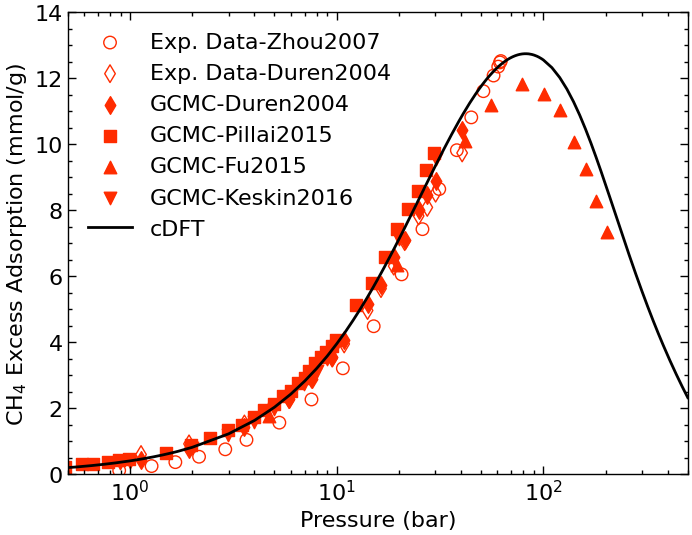

In [67]:
plt.rcParams["lines.markersize"] = 9

plt.scatter(exp_data['Pexc(bar)-300K'],(1e3/mss)*(mss/mff)*exp_data['Nexc(%wt)-300K']*0.01/(1-exp_data['Nexc(%wt)-300K']*0.01),marker='o',edgecolors='C3',facecolors='none',label='Exp. Data-Zhou2007')

plt.scatter(exp_data2['Pressure (atm)']/0.986923,exp_data2['Excess adsorption (cm^3 STP/cm^3)']*(1e3/mss)/(1e30*(kB*273.15/101325)/Vcell),marker='d',edgecolors='C3',facecolors='none',label='Exp. Data-Duren2004')
plt.scatter(exp_data2['Pressure (atm)']/0.986923,exp_data2['Sim Excess adsorption (cm^3 STP/cm^3)']*(1e3/mss)/(1e30*(kB*273.15/101325)/Vcell),marker='d',edgecolors='C3',facecolors='C3',label='GCMC-Duren2004')

#convert from absolute to excess
rhobarray_data3 = rhofromBARpressure300K(exp_data3['Pressure (kPa)']/100)
Nabs_data3 = exp_data3['Absolute adsorption (mmol/g)']/(1e3/mss)
Nexc_data3 = Nabs_data3 - rhobarray_data3*Vpore
plt.scatter(exp_data3['Pressure (kPa)']/100,1e3*Nexc_data3/mss,marker='s',edgecolors='C3',facecolors='C3',label='GCMC-Pillai2015')

#convert from absolute to excess
rhobarray_data4 = rhofromBARpressure300K(exp_data4['Pressure (bar)'])
Nabs_data4 = exp_data4['Absolute adsorption (cm^3 STP/cm^3)']/(1e30*(kB*298.15/101325)/Vcell) # Fu and Wu uses 25ºC and 1 atm as STP?!!?!?
Nexc_data4 = Nabs_data4 - rhobarray_data4*Vpore
plt.scatter(exp_data4['Pressure (bar)'],1e3*Nexc_data4/mss,marker='^',edgecolors='C3',facecolors='C3',label='GCMC-Fu2015')

plt.scatter(exp_data5['Pressure (bar)'],exp_data5['Excess adsorption (mmol/g)'],marker='v',edgecolors='C3',facecolors='C3',label='GCMC-Keskin2016')

plt.plot(df['Pressure (bar)'],df['Excess adsorption (mol/kg)'],'-',color='k',label='cDFT')

plt.legend(loc='upper left')
plt.xlabel('Pressure (bar)')
plt.ylabel('CH$_4$ Excess Adsorption (mmol/g)')
plt.xlim(0.5,500)
plt.ylim(0,14)
# plt.yscale('log')
plt.xscale('log')
plt.savefig('figures/CH4-MOF4-300K.png',dpi=200)